In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
import plotly.graph_objects as go

import plotly.express as px
import pandas as pd
from math import sqrt
from math import log as ln
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [63]:
def build_dataset(H_min, H_maj, mu, n:int, alpha:float, w_star:np.ndarray, sd_eta:float=1., verbose=True):
    """
    Build a dataset according to the parameters.
    H_0:
    mu: vector of group means [mu_min, mu_maj].
    n: total number of samples.
    alpha: Fraction of samples from the majority group.
    sd_eta: sd of the noise in the model, such that y = x^T w_star + eta.
    """
    assert 0 < alpha < 1
    n_maj = int(alpha * n)
    n_min = n - n_maj
    if verbose:
        print(f"[INFO] built dataset with alpha={alpha}, n_maj={n_maj}, n_min={n_min}")
    rng = default_rng()
    eta = rng.normal(0., sd_eta, n)
    X_min = rng.multivariate_normal(mu, H_min, n_min)
    X_maj = rng.multivariate_normal(mu, H_maj, n_maj)
    X = np.vstack((X_min, X_maj))
    # The ith entry in g is zero if the ith element of X is from minority; otherwise one.
    g = np.concatenate((np.zeros(n_min), np.ones(n_maj)))
    y = (X @ w_star) + eta
    return X, g, y


def build_loader(X, y, batch_size=64):
    inputs = torch.from_numpy(X).double()
    targets = torch.from_numpy(y).double()
    train_ds = torch.utils.data.TensorDataset(inputs, targets)
    loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
    return loader


def vanilla_sgd(loader, T, lr, d=2, verbose=True):
    """Implements vanilla SGD for the dataset."""
    w_hat = torch.zeros(size = (d,), dtype=torch.double)
    w_hat.requires_grad = True
    lr = torch.Tensor([lr]).double()
    t = 0
    iterates = list()
    losses = list()
    while t < T:
        for i, (X_i,y_i) in enumerate(loader): # Should be iterating over batches, instead of one pass over dataset
            y_hat = torch.matmul(X_i, w_hat)
            loss = torch.mean((y_i - y_hat)**2)
            # Computes the gradients for all tensors with grad=True
            loss.backward()
            with torch.no_grad():
                w_hat -= lr * w_hat.grad
                w_hat.grad.zero_()
                iterate_numpy = w_hat.clone().detach().numpy()
                loss_numpy = loss.clone().detach().numpy()
                iterates.append(iterate_numpy)
                losses.append(loss_numpy)
            if verbose and (t % 1000 == 0):
                print("iteration {} loss: {} new w_hat: {}".format(t, loss, w_hat.detach().numpy()))
            t += 1
            if t >= T:
                print("[INFO] completed %s iterations of SGD." % t)
                break
    return iterates, losses


def compute_mse_iterates(X, g, iterates, group, tstep):
    """Compute the per-iteration MSE for the specified subgroup of X."""
    T = len(iterates)
    mse_iterates = list()
    X_g = X[g == group, :]
    X_g = torch.from_numpy(X_g).cuda()
    y_g = y[g == group]
    iterates_ary = np.array(iterates)
    for t in tqdm(range(0, T, tstep)):
        w_hat_t = torch.from_numpy(iterates_ary[t,:]).cuda()
        y_hat_t = torch.matmul(X_g, w_hat_t) # shape [n,]     
        y_hat_t = y_hat_t.detach().cpu().numpy()
        mse_t = mean_squared_error(y_true=y_g, y_pred=y_hat_t)
        mse_iterates.append(mse_t)
    # mse_iterates is an array of shape [T,] where the t^th entry is the MSE at iteration T.
    return np.array(mse_iterates)


def gd_plots(losses, iterates, w_star, X, g, plot_every_iters=100):
    """Generate plots of the reuslts of a SGD/DPSGD experiment."""
    d = len(w_star)
    T = len(losses)
    loss_0 =  compute_mse_iterates(X, g, iterates, 0, plot_every_iters)
    loss_1 = compute_mse_iterates(X, g, iterates, 1, plot_every_iters)
    tgrid=np.arange(T, step=plot_every_iters)
    fig, axs = plt.subplots(nrows=1+d, ncols=1, sharex=True, figsize=(15,15))
    axs[0].plot(tgrid, np.array(losses)[tgrid], c="gray", label="Overall")
    axs[0].plot(tgrid, loss_0, c="red", label="Group 0")
    axs[0].plot(tgrid, loss_1, c="black", label="Group 1")
    axs[0].set_title('Loss')
    axs[0].legend(loc='upper right')

    iterates = np.array(iterates)
    for i in range(d):
        axs[i + 1].plot(iterates[:,i], c="blue", label='est')
        axs[i + 1].plot(np.arange(T), w_star[i] * np.ones(T), c="orange", label='true')
        axs[i + 1].legend(loc='lower center')
        axs[1 + 1].set_title('W_{}'.format(i))
        
def compute_sigma_dp(L_1, L_2, L_3, k, delta, eps):
    """Compute sigma_DP."""
    sigma_dp = (2 * (L_2 * L_3 + L_1 * L_3**2) 
                * sqrt(2 * ln(1.25 * 2 * k / delta)) 
                * sqrt(k * ln(2 * n / delta)) 
                / eps)
    return sigma_dp


def compute_L_and_k(X, y, w_star, n, T):
    c = 2  # TODO:confirm value of c.
    L_1 = np.linalg.norm(X, axis=1, ord=2).max()
    L_2 = np.abs(y).max()
    L_3 = np.linalg.norm(w_star, ord=2)
    k = float(T)/n + c * sqrt( (T/n) * ln(2 * n / delta))
    return L_1, L_2, L_3, k
    

def print_dpsgd_diagnostics(L_1, L_2, L_3, k, sigma_dp, n, delta):
    """Print various important quantities used to compute sigma_DP."""
    print(f"L_1 = {L_1}; L_2 = {L_2}; L_3 = {L_3}")
    print(f"k={k}")
    print("(L_2 * L_3 + L_1 * L_3**2): %s" % (L_2 * L_3 + L_1 * L_3**2))
    print("sqrt(2 * ln(1.25 * 2 * k / delta)): %s" % sqrt(2 * ln(1.25 * 2 * k / delta)))
    print("sqrt(k * ln(2 * n / delta)): %s" % sqrt(k * ln(2 * n / delta)))
    print("sigma_dp: %f" % sigma_dp)


def dp_sgd(X, y, T, delta, eps, s, lr, verbose=True, d=2):
    """Implements Algorithm 1 (DP-SGD)."""
    n = len(X)
    # Compute the various constants needed for the algorithm.
    L_1, L_2, L_3, k = compute_L_and_k(X, y, w_star, n, T)
    sigma_dp = compute_sigma_dp(L_1, L_2, L_3, k=k, delta=delta, eps=eps)
    if verbose:
        print_dpsgd_diagnostics(L_1, L_2, L_3, k=k, sigma_dp=sigma_dp, n=n, delta=delta)
    
    # Initialization
    loader = build_loader(X, y)
    t = 0
    w_hat = torch.zeros(size=(d,), dtype=torch.double)
    w_hat.requires_grad = True
    lr = torch.Tensor([lr]).double()
    L_3 = torch.Tensor([L_3,])
    iterates = list()
    losses = list()
    while t < T:
        for i, (X_i, y_i) in enumerate(loader):
            grad_noise = torch.normal(mean=0, std=sigma_dp, size=w_star.shape)
            y_hat = torch.matmul(X_i, w_hat)
            loss = torch.mean((y_i - y_hat)**2)
            loss.backward()

            with torch.no_grad():
                w_hat -= lr * (w_hat.grad + grad_noise)
                
                # Project back onto ball of radius L_3
                w_hat_norm = torch.norm(w_hat)
                w_hat /= w_hat_norm
                w_hat *= L_3
                
                w_hat.grad.zero_()
                iterate_numpy = w_hat.clone().detach().numpy()
                loss_numpy = loss.clone().detach().numpy()
                iterates.append(iterate_numpy)
                losses.append(loss_numpy)

            if verbose and (t % 1000 == 0):
                print("iteration {} loss: {} new w_hat: {}".format(t, loss, iterate_numpy))
            
            t += 1
            if t >= T:
                print("[INFO] completed %s iterations of SGD." % t)
                break
    w_hat = np.vstack(iterates[-(T-s):]).mean(axis=0)
    return iterates, losses, w_hat


def compute_disparity(X:np.array, g:np.array, y:np.array, sgd_w_hat: np.array, dpsgd_w_hat: np.array):
    """Compute the quantity defined as \rho in the paper, along with its constituents."""
    loss_sgd_0 = np.mean(((X[g == 0, :] @ sgd_w_hat) - y[g == 0])**2)
    loss_sgd_1 = np.mean(((X[g == 1, :] @ sgd_w_hat) - y[g == 1])**2)
    loss_dpsgd_0 = np.mean(((X[g == 0, :] @ dpsgd_w_hat) - y[g == 0])**2)
    loss_dpsgd_1 = np.mean(((X[g == 1, :] @ dpsgd_w_hat) - y[g == 1])**2)
    rho = (loss_dpsgd_0 - loss_dpsgd_1) / (loss_sgd_0 - loss_sgd_1)
    print(f"loss_dpsgd_0: {loss_dpsgd_0}")
    print(f"loss_dpsgd_1: {loss_dpsgd_1}")
    print(f"loss_sgd_0: {loss_sgd_0}")
    print(f"loss_sgd_1: {loss_sgd_1}")
    print("[INFO] rho : {} = {} / {}".format(rho, loss_dpsgd_0 - loss_dpsgd_1, loss_sgd_0 - loss_sgd_1))
    metrics = {"rho":rho, 
               "loss_dpsgd_0":loss_dpsgd_0, 
               "loss_dpsgd_1":loss_dpsgd_1, 
               "loss_sgd_0":loss_sgd_0, 
               "loss_sgd_1":loss_sgd_1}
    return metrics

In [4]:
# H_min = [[1, 0], [0, 1]]
# H_maj = [[0.5, 0], [0, 0.5]]
# mu = [0, 0]
# w_star = np.array([1,-1])
# n = 10**6
# d=2
# alpha = 0.99
# sigma_noise = 1.

H_min = [[0., 0., 0.,], [0., 0., 0.], [0., 0., 1.]]
H_maj = [[1., 0., 0.], [0., 0.1, 0.], [0., 0., 0.]]
mu = [0, 0, 0]
w_star = np.array([1,-1, 2])
n = 10**6
d=3
sigma_noise=1.
alpha=0.9

lr=0.001


X, g, y = build_dataset(H_min=H_min, H_maj=H_maj, mu=mu, n=n, alpha=alpha, w_star=w_star, sd_eta=sigma_noise)
loader = build_loader(X, y)

[INFO] built dataset with alpha=0.9, n_maj=900000, n_min=100000


In [5]:
if d == 2:
    MAX_TO_PLOT = 10**4

    # Build a point set for the ground truth xyz-plane
    xgrid = np.arange(-20, 20, 1)
    x1grid, x2grid = np.meshgrid(xgrid, xgrid)
    grid = np.column_stack((np.ravel(x1grid), np.ravel(x2grid)))
    zgrid = (grid @ w_star)
    plotly_zgrid = np.reshape(zgrid, (len(xgrid), len(xgrid)))  # plotly requires this layout
    surface_coords = np.column_stack((grid[:,0], grid[:,1], zgrid))

    # Stack the data into a pd.DataFrame for plotly
    data = np.hstack((X, np.expand_dims(y, 1), np.expand_dims(g, 1)))
    df = pd.DataFrame(data)
    df.columns = ['X1', 'X2', 'y', 'g']

    df = df.sample(n=MAX_TO_PLOT)

In [6]:
if d == 2:

    scolor = np.zeros((60,60))
    cmap = plt.get_cmap("Greys")
    colorscale = [[0, 'rgb' + str(cmap(1)[0:3])], 
                  [1, 'rgb' + str(cmap(2)[0:3])]]

    fig = go.Figure(data=[
        go.Scatter3d(x=df['X1'], y=df['X2'], z=df['y'],
                                       mode='markers'),
                         go.Surface(x=xgrid,
                                   y=xgrid,
                                   z=plotly_zgrid,
                                    opacity=0.25,
                                   surfacecolor=scolor,
                                   cmin=0,
                                   cmax=1,
                                   colorscale=colorscale)
                         ])

    fig.update_traces(marker=dict(size=2.5,
                                  color=1-df['g'],
                                  opacity=0.95,
                                  colorscale="bluered"
                                 ),
                      selector=dict(mode='markers'))
    # Formatting
    fig.update_layout(title_text="Data With True Parameter Surface (Sample Shown)", autosize=False,
                      width=1000, height=1000
    )
    fig.show()

In [10]:
sgd_iterates, sgd_losses = vanilla_sgd(loader, T=10000, verbose=False, lr=lr, d=d)

[INFO] completed 10000 iterations of SGD.


100%|██████████| 100/100 [00:00<00:00, 130.98it/s]


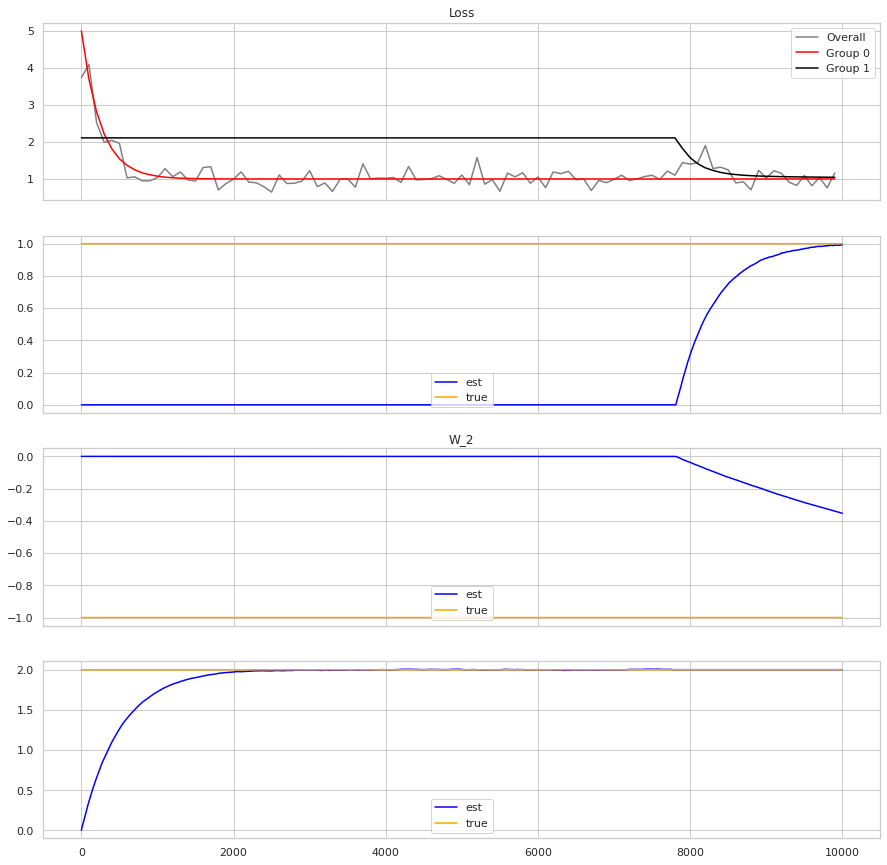

In [64]:
gd_plots(sgd_losses, sgd_iterates, w_star, X, g)

In [12]:
delta=0.01
eps = 50.0
s = 5000
T = 10000

In [14]:
dpsgd_iterates, dpsgd_losses, dpsgd_w_hat = dp_sgd(X=X, y=y, T=T, delta=delta, eps=eps, s=s, lr=lr, d=d, verbose=False)

L_1 = 5.087394465441925; L_2 = 10.343023086808667; L_3 = 2.449489742783178
k=0.8843872808890192
(L_2 * L_3 + L_1 * L_3**2): 55.85949575315898
sqrt(2 * ln(1.25 * 2 * k / delta)): 3.2859095258795286
sqrt(k * ln(2 * n / delta)): 4.11145063274996
sigma_dp: 30.186147
iteration 0 loss: 3.645093691922166 new w_hat: [ 0.43326622 -1.92596482  1.45015183]
iteration 1000 loss: 0.9317992515535316 new w_hat: [ 0.58397035 -0.44255854  2.33733203]
iteration 2000 loss: 1.190806864090004 new w_hat: [ 0.72155706 -0.77977039  2.20710534]
iteration 3000 loss: 1.4132822873614952 new w_hat: [ 0.34218447 -1.53942925  1.87431796]
iteration 4000 loss: 1.6553872032758328 new w_hat: [ 0.03917041 -2.18162278  1.11309844]
iteration 5000 loss: 1.0191873887887066 new w_hat: [ 1.12080498 -1.83784662  1.16880984]
iteration 6000 loss: 1.5552507838404774 new w_hat: [ 1.57965294 -1.79176729  0.54246382]
iteration 7000 loss: 1.2154695203023145 new w_hat: [ 1.47202642 -1.60276675 -1.1244009 ]
iteration 8000 loss: 0.9021463

Experimental Notes:
* Very small learning rate (lr \approx 0.0001) works well; setting to >= 0.001 gave bad results.
* Increasing number of iterations, using small learning rate, and a fairly large s gives good results in practice (choose s to disregard first 1/3 or so iterations).
* Need to set number of iterations fairly large, because the magnitude of the noise is also quite large compared to the gradients; many iterations are required to get reasonable parameter estimates.

In [15]:
print("DPSGD parameter estimates with burn-in applied:")
print(dpsgd_w_hat)
print("True parameters w*:")
print(w_star)

DPSGD parameter estimates with burn-in applied:
[ 1.15773538 -1.57290442 -1.02501959]
True parameters w*:
[ 1 -1  2]


100%|██████████| 100/100 [00:00<00:00, 124.34it/s]


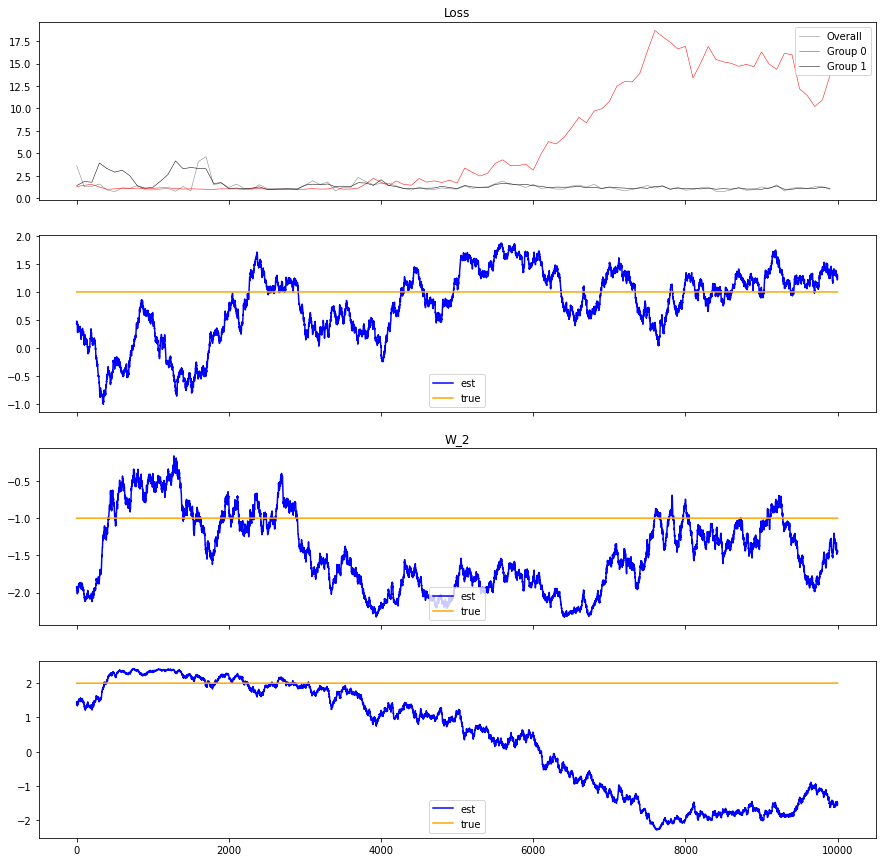

In [16]:
gd_plots(dpsgd_losses, dpsgd_iterates, w_star, X, g)

In [28]:
alphagrid = (0.999, 0.99, 0.975, 0.95, 0.9, 0.7, 0.5)

In [29]:
results = list()
for i in range(10):
    for alpha in alphagrid:
        print("Computing for alpha %s" % alpha)
        X_tr, g_tr, y_tr = build_dataset(H_min=H_min, H_maj=H_maj, mu=mu, n=n, alpha=alpha, w_star=w_star)
        X_te, g_te, y_te = build_dataset(H_min=H_min, H_maj=H_maj, mu=mu, n=n, alpha=0.5, w_star=w_star)
        loader_tr = build_loader(X_tr, y_tr)
        sgd_iterates, sgd_losses = vanilla_sgd(loader_tr, T=T, lr=lr, verbose=False, d=d)
        sgd_w_hat = sgd_iterates[-1]
        dpsgd_iterates, dpsgd_losses, dpsgd_w_hat = dp_sgd(
            X=X_tr, y=y_tr, T=T, delta=delta, eps=eps, s=s, lr=lr, verbose=False, d=d)
        metrics = compute_disparity(X_te, g_te, y_te, sgd_w_hat, dpsgd_w_hat)
        rho_alpha = metrics["rho"]
        print(f"iteration {i} alpha {alpha}: disparity {rho_alpha}")
        print("sgd_w_hat: {}".format(sgd_w_hat))
        print("dpsgd_w_hat: {}".format(dpsgd_w_hat))
        results.append((i, alpha, rho_alpha, sgd_w_hat, dpsgd_w_hat, 
                        metrics["loss_dpsgd_0"], metrics["loss_dpsgd_1"], 
                        metrics["loss_sgd_0"], metrics["loss_sgd_1"]))
df = pd.DataFrame(results)
df.columns=["i", "alpha", "rho_alpha", "sgd_w_hat", "dpsgd_w_hat", 
            "loss_dpsgd_0", "loss_dpsgd_1", "loss_sgd_0", "loss_sgd_1"]
df["delta_sgd"] = df["loss_sgd_0"] - df["loss_sgd_1"]
df["delta_dpsgd"] = df["loss_dpsgd_0"] - df["loss_dpsgd_1"] 

Computing for alpha 0.999
[INFO] built dataset with alpha=0.999, n_maj=999000, n_min=1000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 14.53145510338942
loss_dpsgd_1: 1.4039350788332376
loss_sgd_0: 4.793889951765739
loss_sgd_1: 1.0022014548972962
[INFO] rho : 3.4621831501712776 = 13.127520024556183 / 3.791688496868443
iteration 0 alpha 0.999: disparity 3.4621831501712776
sgd_w_hat: [ 1.00787196 -0.86694799  0.05556642]
dpsgd_w_hat: [ 1.40186314  0.55750631 -1.67220848]
Computing for alpha 0.99
[INFO] built dataset with alpha=0.99, n_maj=990000, n_min=10000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.1755612476609865
loss_dpsgd_1: 1.2806409703302153
loss_sgd_0: 3.14833579805202
loss_sgd_1: 1.0006030916682378
[INFO] rho : -0.04892588465822429 = -0.1050797

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.7132262380688614
loss_dpsgd_1: 1.1215279312941375
loss_sgd_0: 4.7734332034443705
loss_sgd_1: 1.0005844612321366
[INFO] rho : 0.15683064633748817 = 0.5916983067747239 / 3.7728487422122337
iteration 2 alpha 0.999: disparity 0.15683064633748817
sgd_w_hat: [ 0.99915014 -0.86696959  0.06144683]
dpsgd_w_hat: [ 1.32653061 -1.39500206  1.15568953]
Computing for alpha 0.99
[INFO] built dataset with alpha=0.99, n_maj=990000, n_min=10000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 15.701224352826642
loss_dpsgd_1: 1.1040301072646348
loss_sgd_0: 3.136008166753637
loss_sgd_1: 1.0005611303709767
[INFO] rho : 6.835662040248452 = 14.597194245562008 / 2.1354470363826605
iteration 2 alpha 0.99: disparity 6.835662040248452
sgd_w

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.2779610105537142
loss_dpsgd_1: 1.3342527221065366
loss_sgd_0: 4.7604326331874525
loss_sgd_1: 0.9985252770315406
[INFO] rho : -0.014963609207629118 = -0.05629171155282231 / 3.7619073561559118
iteration 4 alpha 0.999: disparity -0.014963609207629118
sgd_w_hat: [ 1.00325831 -0.86338355  0.05949582]
dpsgd_w_hat: [1.30204889 0.56957528 1.47509141]
Computing for alpha 0.99
[INFO] built dataset with alpha=0.99, n_maj=990000, n_min=10000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.0231361445450515
loss_dpsgd_1: 1.3487741134072309
loss_sgd_0: 3.1569375810800797
loss_sgd_1: 0.9998729317677603
[INFO] rho : -0.1509634720340876 = -0.32563796886217933 / 2.1570646493123196
iteration 4 alpha 0.99: disparity -0.150963472034

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 2.490515713861265
loss_dpsgd_1: 1.0910229780601965
loss_sgd_0: 4.741575597064437
loss_sgd_1: 0.9995086214130932
[INFO] rho : 0.37398922705210874 = 1.3994927358010685 / 3.742066975651344
iteration 6 alpha 0.999: disparity 0.37398922705210874
sgd_w_hat: [ 0.99854893 -0.86507334  0.06399312]
dpsgd_w_hat: [ 1.07881001 -1.92883796  0.77809037]
Computing for alpha 0.99
[INFO] built dataset with alpha=0.99, n_maj=990000, n_min=10000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 10.106933844239471
loss_dpsgd_1: 1.8091682664650868
loss_sgd_0: 3.1430707204882933
loss_sgd_1: 1.004435735077138
[INFO] rho : 3.8799353954172453 = 8.297765577774385 / 2.138634985411155
iteration 6 alpha 0.99: disparity 3.8799353954172453
sgd_w_ha

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 3.35307991534206
loss_dpsgd_1: 2.007766169577394
loss_sgd_0: 4.747020238241194
loss_sgd_1: 1.0026265834066483
[INFO] rho : 0.3592874760984798 = 1.345313745764666 / 3.7443936548345453
iteration 8 alpha 0.999: disparity 0.3592874760984798
sgd_w_hat: [ 1.01061718 -0.86731801  0.06241145]
dpsgd_w_hat: [0.86258969 2.15205168 0.4639532 ]
Computing for alpha 0.99
[INFO] built dataset with alpha=0.99, n_maj=990000, n_min=10000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 14.808661394529361
loss_dpsgd_1: 1.0359881677694398
loss_sgd_0: 3.143917138230481
loss_sgd_1: 1.0003160462717864
[INFO] rho : 6.425016892567113 = 13.77267322675992 / 2.1436010919586943
iteration 8 alpha 0.99: disparity 6.425016892567113
sgd_w_hat: [ 1.0

In [191]:
df[["i", "alpha", "rho_alpha", "loss_dpsgd_0", 
    "loss_dpsgd_1", "loss_sgd_0", "loss_sgd_1"]].to_csv("./rscripts/data/lr-rho-alpha/lr_rho_alpha.csv", index=False)

<AxesSubplot:xlabel='alpha', ylabel='delta_sgd'>

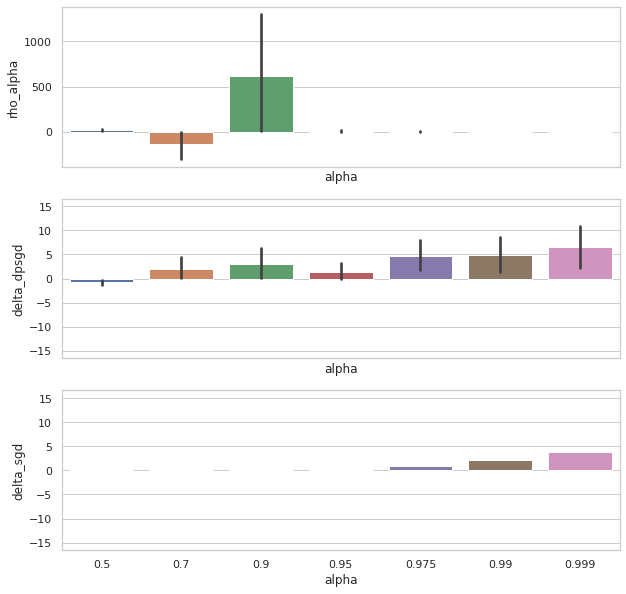

In [31]:

sns.set_theme(style="whitegrid")

delta_rng = np.abs(df[["delta_sgd", "delta_dpsgd"]].values).max()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,10))
sns.barplot(ax=axes[0], x="alpha", y="rho_alpha", data=df)
axes[1].set_ylim([-delta_rng,delta_rng])
sns.barplot(ax=axes[1], x="alpha", y="delta_dpsgd", data=df)
axes[2].set_ylim([-delta_rng,delta_rng])
sns.barplot(ax=axes[2], x="alpha", y="delta_sgd", data=df)

<AxesSubplot:xlabel='alpha', ylabel='loss_sgd_1'>

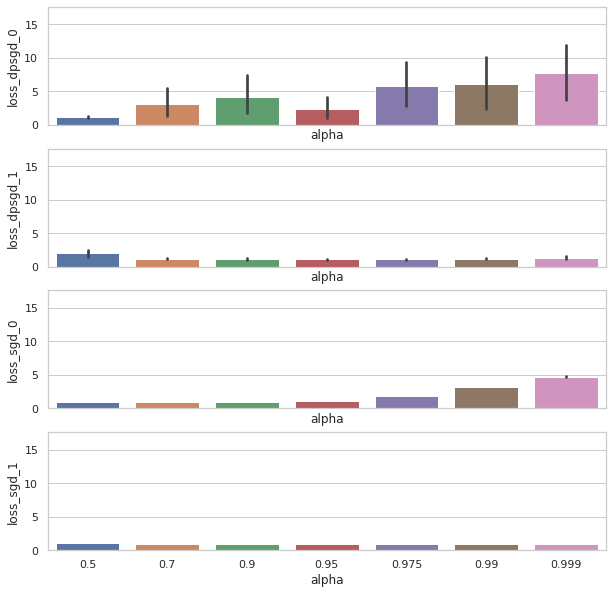

In [32]:
y_rng = np.abs(df[["loss_dpsgd_0", "loss_dpsgd_1", "loss_sgd_0", "loss_sgd_1"]].values).max()
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,10))
for ax in axes.flatten():
    ax.set_ylim([0, y_rng])
sns.barplot(ax=axes[0], x="alpha", y="loss_dpsgd_0", data=df)
sns.barplot(ax=axes[1], x="alpha", y="loss_dpsgd_1", data=df)
sns.barplot(ax=axes[2], x="alpha", y="loss_sgd_0", data=df)
sns.barplot(ax=axes[3], x="alpha", y="loss_sgd_1", data=df)

Text(0.5, 1.0, 'DP-SGD Disparity in Linear Regression')

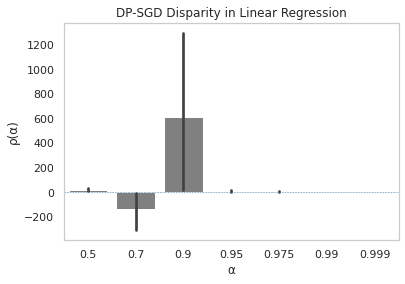

In [146]:

sns.set_theme(style="whitegrid")

delta_rng = np.abs(df[["delta_sgd", "delta_dpsgd"]].values).max()

ax = sns.barplot(x="alpha", y="rho_alpha", data=df, color="grey")
ax.axhline(0, ls='--', lw=0.5)
ax.grid(False)
ax.set_xlabel("\u03B1")
ax.set_ylabel("\u03C1(\u03B1)")
ax.set_title("DP-SGD Disparity in Linear Regression")

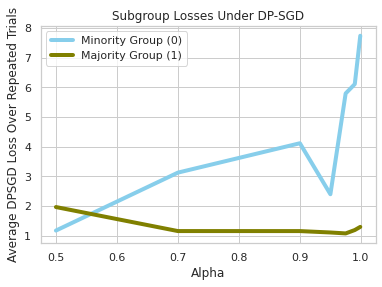

In [61]:
avg_results = df.groupby('alpha').mean().reset_index()

plt.plot('alpha', 'loss_dpsgd_0', data=avg_results, color='skyblue', linewidth=4, label="Minority Group (0)")
plt.plot('alpha', 'loss_dpsgd_1', data=avg_results, color='olive', linewidth=4, label="Majority Group (1)")
plt.ylabel("Average DP-SGD Loss Over Repeated Trials")
plt.xlabel("Alpha")
plt.title("Subgroup Losses Under DP-SGD")
plt.legend()

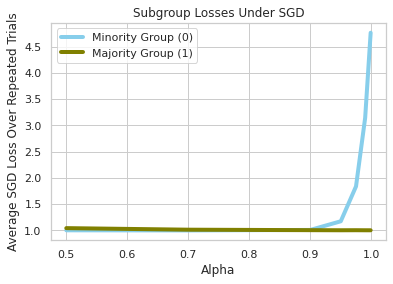

In [62]:
plt.plot('alpha', 'loss_sgd_0', data=avg_results, color='skyblue', linewidth=4, label="Minority Group (0)")
plt.plot('alpha', 'loss_sgd_1', data=avg_results, color='olive', linewidth=4, label="Majority Group (1)")
plt.ylabel("Average SGD Loss Over Repeated Trials")
plt.xlabel("Alpha")
plt.title("Subgroup Losses Under SGD")
plt.legend()

In [33]:
def compute_rho_lr(H_min:np.array, H_maj:np.array, alpha, sigma_dp, sigma_noise=1.):
    """Compute the quantity defined as \rho_{LR} in the paper."""
    H = alpha * H_maj + (1 - alpha) * H_min
    H_inv = np.linalg.pinv(H)
    H_minus2 = np.matmul(H_inv, H_inv)
    rho_lr = (
        np.trace((H_min - H_maj) @ H_minus2) * sigma_dp**2 
        / (np.trace((H_min - H_maj) @ H_inv) * sigma_noise**2)
    )
    return rho_lr

In [152]:
alpha_rho_lr = list()
for alpha in np.arange(0, 1, 0.0001)[1:-1]:
    rho_lr = compute_rho_lr(np.array(H_min), np.array(H_maj), alpha=alpha, sigma_dp=178.558658)
    alpha_rho_lr.append((alpha, rho_lr))

/homes/gws/jpgard/differential-privacy-vs-fairness/venv/lib64/python3.6/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8 rows containing missing values.


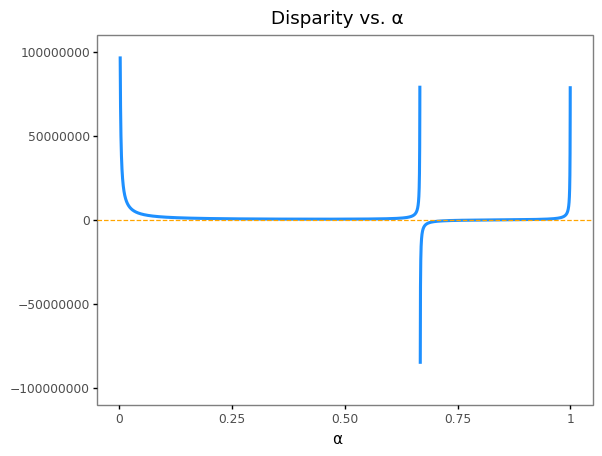

<ggplot: (-9223363270364900201)>

In [153]:
# data = np.array(alpha_rho_lr)
# plt.plot(data[:,0], data[:,1], ls='-', marker='.')
# plt.title("rho_LR")
# plt.xlabel('alpha')
from plotnine import *
data = pd.DataFrame(alpha_rho_lr)
data.columns = ["alpha","rho_LR"]
data["grp"] = (data["alpha"] < 0.667).astype(int)
ggplot(data) + aes(x="alpha", y="rho_LR") +\
geom_line(aes(group="grp"), color="dodgerblue", size=1.25) + theme_bw() +\
theme(panel_grid_major = element_blank(), 
        panel_grid_minor = element_blank()) +\
ggtitle("Disparity vs. \u03B1") +\
ylab("") + \
ylim(-100000000, 100000000) +\
geom_hline(yintercept=0, color="orange", linetype="dashed") +\
xlab("\u03B1")

In [193]:
data.to_csv("./rscripts/data/lr-rho-alpha/rho_lr_values.csv", index=False)

In [116]:
data[data.alpha < 0.67]

,alpha,rho_LR,grp
0,0.500,6.376639e+05,1
1,0.501,6.384388e+05,1
2,0.502,6.392334e+05,1
3,0.503,6.400480e+05,1
4,0.504,6.408828e+05,1
...,...,...,...
165,0.665,2.267711e+07,1
166,0.666,5.615435e+07,1
167,0.667,-1.112325e+08,1
168,0.668,-2.753925e+07,1


In [45]:
# playground
df[(df.alpha==0.9) & (df.rho_alpha > 1000)]

,i,alpha,rho_alpha,sgd_w_hat,dpsgd_w_hat,loss_dpsgd_0,loss_dpsgd_1,loss_sgd_0,loss_sgd_1,delta_sgd,delta_dpsgd
18,2,0.9,1641.187084,"[0.9957646634697572, -0.8124736865424782, 1.90...","[0.6996008503370614, -1.8396778339522386, -1.2...",11.595176,1.161165,1.010297,1.003940,0.006358,10.434010
25,3,0.9,1825.379419,"[1.001302737979882, -0.8197906295480952, 1.904...","[1.3392608624514635, 1.7974808824763946, -0.72...",8.446972,1.895443,1.007912,1.004323,0.003589,6.551529
53,7,0.9,2638.200957,"[0.9986953062597571, -0.8227400371099113, 1.91...","[1.0610904278629851, -1.2692824605961313, -1.5...",13.615077,1.009100,1.006704,1.001926,0.004778,12.605977


# Analysis of $\phi$

In [183]:
# H_maj = [[8., 0., 0.,], [0., 8., 0.], [0., 0., 8.]]
# H_min = np.diag([1.,] * 3)
mu = [0, 0, 0]


phi_results = list()
h_min = 1.
for h_maj in (4., 2., 1., 0.5, 0.25):
    H_maj = np.diag([h_maj,] * d)
    H_min = np.diag([h_min,] * d)
    for eps in (12.5, 25., 50.):
        for i in range(1):
            for alpha in (0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99):
                print("Computing for alpha %s" % alpha)
                X_tr, g_tr, y_tr = build_dataset(H_min=H_min, H_maj=H_maj, mu=mu, n=n, alpha=alpha, w_star=w_star)
                X_te, g_te, y_te = build_dataset(H_min=H_min, H_maj=H_maj, mu=mu, n=n, alpha=0.5, w_star=w_star)
                loader_tr = build_loader(X_tr, y_tr)
                sgd_iterates, sgd_losses = vanilla_sgd(loader_tr, T=T, lr=lr, verbose=False, d=d)
                sgd_w_hat = sgd_iterates[-1]
                dpsgd_iterates, dpsgd_losses, dpsgd_w_hat = dp_sgd(
                    X=X_tr, y=y_tr, T=T, delta=delta, eps=eps, s=s, lr=lr, verbose=False, d=d)
                metrics = compute_disparity(X_te, g_te, y_te, sgd_w_hat, dpsgd_w_hat)
                print(f"iteration {i} alpha {alpha}: disparity {rho_alpha}")
                print("sgd_w_hat: {}".format(sgd_w_hat))
                print("dpsgd_w_hat: {}".format(dpsgd_w_hat))
                phi_results.append((i, alpha, eps, delta, h_maj, h_min, sgd_w_hat, dpsgd_w_hat, 
                                metrics["loss_dpsgd_0"], metrics["loss_dpsgd_1"], 
                                metrics["loss_sgd_0"], metrics["loss_sgd_1"]))
phi_results_df = pd.DataFrame(phi_results)
phi_results_df.columns=["i", "alpha", "eps", "delta", "h_maj", "h_min", "sgd_w_hat", "dpsgd_w_hat", 
            "loss_dpsgd_0", "loss_dpsgd_1", "loss_sgd_0", "loss_sgd_1"]
phi_results_df["delta_sgd"] = phi_results_df["loss_sgd_0"] - phi_results_df["loss_sgd_1"]
phi_results_df["delta_dpsgd"] = phi_results_df["loss_dpsgd_0"] - phi_results_df["loss_dpsgd_1"] 

Computing for alpha 0.01
[INFO] built dataset with alpha=0.01, n_maj=10000, n_min=990000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 5.917993376367929
loss_dpsgd_1: 20.64755444060806
loss_sgd_0: 1.004505525002024
loss_sgd_1: 0.9985930617703885
[INFO] rho : -2491.2731778909683 = -14.729561064240134 / 0.005912463231635523
iteration 0 alpha 0.01: disparity 27.72216337989135
sgd_w_hat: [ 1.00236483 -0.99965736  2.00044291]
dpsgd_w_hat: [-0.27209195 -0.3927607   0.28957418]
Computing for alpha 0.05
[INFO] built dataset with alpha=0.05, n_maj=50000, n_min=950000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 6.179655760853933
loss_dpsgd_1: 21.850326535979022
loss_sgd_0: 0.9987780601477568
loss_sgd_1: 0.9979656849729454
[INFO] rho : -19289.942948788073 = -15.67067

[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.3812055771134315
loss_dpsgd_1: 2.525514894712526
loss_sgd_0: 1.002302011515464
loss_sgd_1: 0.9985934539544092
[INFO] rho : -308.55913620325634 = -1.1443093175990946 / 0.003708557561054704
iteration 0 alpha 0.7: disparity 27.72216337989135
sgd_w_hat: [ 0.9961955  -1.00497145  1.99899382]
dpsgd_w_hat: [ 0.76553405 -0.49678888  1.73126238]
Computing for alpha 0.9
[INFO] built dataset with alpha=0.9, n_maj=900000, n_min=100000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.2069457611703098
loss_dpsgd_1: 1.8396706345867007
loss_sgd_0: 0.9992770021842384
loss_sgd_1: 1.0008499101402157
[INFO] rho : 402.26439888738054 = -0.6327248734163908 / -0.0015729079559773096
iteration 0 alpha 0.9: disparity 27.72216337989135
sgd_w_hat: [ 1.00784473 -1.00892374  2.00789406]
dpsgd_w_hat: [ 0.9

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 3.431913744443968
loss_dpsgd_1: 5.862541220668481
loss_sgd_0: 0.9964196103983576
loss_sgd_1: 1.001171489877315
[INFO] rho : 511.50865399427556 = -2.430627476224513 / -0.004751879478957388
iteration 0 alpha 0.05: disparity 27.72216337989135
sgd_w_hat: [ 0.99551283 -1.00411043  1.99713542]
dpsgd_w_hat: [ 0.43274873 -0.27749267  0.73920629]
Computing for alpha 0.1
[INFO] built dataset with alpha=0.1, n_maj=100000, n_min=900000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 5.403069313835352
loss_dpsgd_1: 9.78296841863555
loss_sgd_0: 0.9982644373108497
loss_sgd_1: 0.9980976644305916
[INFO] rho : -26262.657921486552 = -4.379899104800198 / 0.00016677288025812587
iteration 0 alpha 0.1: disparity 27.72216337989135
sgd_w_h

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.8348741512746258
loss_dpsgd_1: 2.666867019219424
loss_sgd_0: 0.9991039008048147
loss_sgd_1: 0.9983997580098802
[INFO] rho : -1181.5683891535468 = -0.8319928679447983 / 0.0007041427949344703
iteration 0 alpha 0.9: disparity 27.72216337989135
sgd_w_hat: [ 0.99688125 -1.00004336  2.00654497]
dpsgd_w_hat: [ 0.78847759 -0.13082851  1.81590651]
Computing for alpha 0.95
[INFO] built dataset with alpha=0.95, n_maj=950000, n_min=50000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.2578971041764508
loss_dpsgd_1: 1.5179748678464495
loss_sgd_0: 0.9979969886037285
loss_sgd_1: 1.0029557862601606
[INFO] rho : 52.447746750193154 = -0.2600777636699987 / -0.004958797656432035
iteration 0 alpha 0.95: disparity 27.72216337989135


[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 3.4964805420389187
loss_dpsgd_1: 3.501142007415528
loss_sgd_0: 0.9992589232553775
loss_sgd_1: 1.0028244697022755
[INFO] rho : 1.307363526470038 = -0.004661465376609275 / -0.0035655464468979936
iteration 0 alpha 0.1: disparity 27.72216337989135
sgd_w_hat: [ 0.99362305 -1.00359961  1.99246435]
dpsgd_w_hat: [ 0.0684938  -1.06877409  0.72918107]
Computing for alpha 0.3
[INFO] built dataset with alpha=0.3, n_maj=300000, n_min=700000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 2.028791725295387
loss_dpsgd_1: 2.0277937560328763
loss_sgd_0: 0.9982768017364764
loss_sgd_1: 0.9989879325036366
[INFO] rho : -1.4033554848088217 = 0.0009979692625106118 / -0.0007111307671602285
iteration 0 alpha 0.3: disparity 27.7221633798913

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.448308550013481
loss_dpsgd_1: 1.4439335780924871
loss_sgd_0: 0.9996520096020323
loss_sgd_1: 0.9956162848731466
[INFO] rho : 1.0840610336180594 = 0.0043749719209937865 / 0.004035724728885692
iteration 0 alpha 0.95: disparity 27.72216337989135
sgd_w_hat: [ 1.0013126  -1.00329567  2.00202187]
dpsgd_w_hat: [ 0.59027573 -0.50215094  1.8141298 ]
Computing for alpha 0.99
[INFO] built dataset with alpha=0.99, n_maj=990000, n_min=10000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.4267632564072852
loss_dpsgd_1: 1.4243021155888438
loss_sgd_0: 0.9998277867548131
loss_sgd_1: 1.0001179411759114
[INFO] rho : -8.482175832874828 = 0.0024611408184413985 / -0.0002901544210982543
iteration 0 alpha 0.99: disparity 27.72216337989

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 3.630016954271665
loss_dpsgd_1: 2.3061846138910713
loss_sgd_0: 1.0000610278935187
loss_sgd_1: 0.9997493347290941
[INFO] rho : 4247.229299444232 = 1.3238323403805938 / 0.00031169316442458683
iteration 0 alpha 0.3: disparity 27.72216337989135
sgd_w_hat: [ 0.99547756 -0.9972939   2.00602754]
dpsgd_w_hat: [ 0.31087146 -0.06584612  0.86945511]
Computing for alpha 0.5
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 5.4289314200348455
loss_dpsgd_1: 3.213633892660409
loss_sgd_0: 0.9961729010569179
loss_sgd_1: 1.0013007034848287
[INFO] rho : -432.0169426412586 = 2.2152975273744366 / -0.005127802427910777
iteration 0 alpha 0.5: disparity 27.72216337989135
sgd_w_

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.18218743973261
loss_dpsgd_1: 1.0887106439924943
loss_sgd_0: 1.00169386444226
loss_sgd_1: 1.0010622782583956
[INFO] rho : 148.0032307992777 = 0.09347679574011569 / 0.0006315861838643855
iteration 0 alpha 0.99: disparity 27.72216337989135
sgd_w_hat: [ 1.00214412 -0.9936338   2.00226395]
dpsgd_w_hat: [ 0.84715717 -0.63521679  1.84851166]
Computing for alpha 0.01
[INFO] built dataset with alpha=0.01, n_maj=10000, n_min=990000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.048644542599507
loss_dpsgd_1: 1.0249738465842337
loss_sgd_0: 0.9984977492350249
loss_sgd_1: 1.0010175065626985
[INFO] rho : -9.394037971556315 = 0.023670696015273274 / -0.002519757327673622
iteration 0 alpha 0.01: disparity 27.72216337989135
sgd_

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 5.372035114666492
loss_dpsgd_1: 2.086039926013928
loss_sgd_0: 1.0000957806704864
loss_sgd_1: 0.9986768688459607
[INFO] rho : 2315.8558071436123 = 3.2859951886525636 / 0.0014189118245256926
iteration 0 alpha 0.5: disparity 27.72216337989135
sgd_w_hat: [ 1.00124484 -1.00116199  1.99869038]
dpsgd_w_hat: [-0.2990223   0.01742457  0.72448714]
Computing for alpha 0.7
[INFO] built dataset with alpha=0.7, n_maj=700000, n_min=300000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 6.160088326229542
loss_dpsgd_1: 2.286990324993184
loss_sgd_0: 1.0019519070144731
loss_sgd_1: 0.9993934722519955
[INFO] rho : 1513.8545090301927 = 3.873098001236358 / 0.002558434762477635
iteration 0 alpha 0.7: disparity 27.72216337989135
sgd_w_hat:

[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.0204811764374149
loss_dpsgd_1: 1.0052095237034273
loss_sgd_0: 1.001573324048101
loss_sgd_1: 1.00046205843445
[INFO] rho : 13.742576523907049 = 0.015271652733987562 / 0.0011112656136511578
iteration 0 alpha 0.01: disparity 27.72216337989135
sgd_w_hat: [ 0.99222474 -0.99777947  2.01154452]
dpsgd_w_hat: [ 0.89157652 -0.97452531  1.92016988]
Computing for alpha 0.05
[INFO] built dataset with alpha=0.05, n_maj=50000, n_min=950000
[INFO] built dataset with alpha=0.5, n_maj=500000, n_min=500000
[INFO] completed 10000 iterations of SGD.
[INFO] completed 10000 iterations of SGD.
loss_dpsgd_0: 1.0780820886381965
loss_dpsgd_1: 1.0210518481113287
loss_sgd_0: 0.9986696261304808
loss_sgd_1: 1.000681734101683
[INFO] rho : -28.34352894730397 = 0.05703024052686789 / -0.002012107971202104
iteration 0 alpha 0.05: disparity 27.72216337989135
sg

In [184]:
phi_results_df["phi_alpha"] = (phi_results_df["loss_dpsgd_0"] - phi_results_df["loss_sgd_0"])/(phi_results_df["loss_dpsgd_1"] - phi_results_df["loss_sgd_1"])

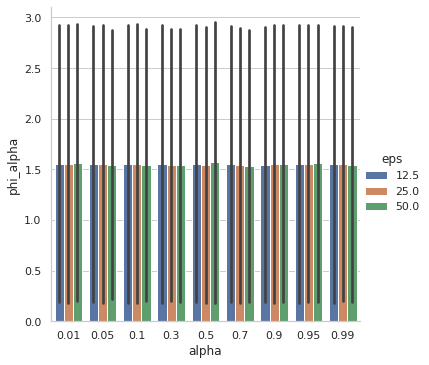

In [186]:
# TODO(jpgard): update this to account for different values of h_maj, h_min.
sns.set_theme(style="whitegrid")
ax = sns.catplot(kind="bar", x="alpha", y="phi_alpha", hue="eps", ci="sd", data=phi_results_df)
# ax.set_ylim(0,1)

In [169]:
phi_results_df["phi_alpha"].mean()

0.1249057044370562

In [176]:
import os;os.getcwd()

'/homes/gws/jpgard/differential-privacy-vs-fairness'

In [187]:
phi_results_df[["i", "alpha", "eps", "delta", "h_maj", "h_min",
                "loss_dpsgd_0", "loss_dpsgd_1", "loss_sgd_0", 
                "loss_sgd_1", "delta_sgd", "delta_dpsgd", "phi_alpha"]
              ].to_csv("./rscripts/data/lr-phi-alpha/lr_phi_alpha.csv", index=False)

In [181]:
np.diag([8.,]*3)

array([[8., 0., 0.],
       [0., 8., 0.],
       [0., 0., 8.]])

In [182]:
d

3